# Hypoxia Oscillations Multicellular Simulation

## imports

In [1]:
import os
import numpy as np
import random
import copy
import cv2
import ast
from scipy import constants
from vivarium.core.process import Process, Step
from vivarium.core.composer import Composer
from vivarium.core.engine import Engine
from vivarium.library.units import units, remove_units

import matplotlib.pyplot as plt
from matplotlib import gridspec, cm
# import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle
import imageio.v2 as imageio
import base64
from IPython.display import Image, display
import ast  # for parsing string to tuple
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt, find_peaks, get_window

## Vivarium Processes

### SimpleCell Process

In [2]:
class SimpleCell(Process):
    """
    A cell model with HIF, lactate, and GFP, following this system of equations:
        dHIF = ksxs + ksx*(HIF^2)/(kpx + HIF^2) - kdx*HIF - kdsx*HIF*lactate
        dlactate = ksy*HIF^2/(kpy + HIF^2) - kdy*lactate
        dGFP = Vg*HIF^3/(kg+HIF^3) - dg*GFP

    Latex equations:
        \frac{dHIF}{dt} = k_{sxs} + \frac{k_{sx}HIF^2}{k_{px} + HIF^2} - k_{dx}HIF - k_{dsx}HIF*lactate
        \frac{dlactate}{dt} = \frac{k_{sy}HIF^2}{k_{py} + HIF^2} - k_{dy}lactate
        \frac{dGFP}{dt} = \frac{V_gHIF^3}{k_g+HIF^3} - d_gGFP

    """

    defaults = {
        'k_HIF_production_basal': 0.02,     # k_sxs
        'k_HIF_production_max': 0.9,        # k_sx
        'k_HIF_pos_feedback': 1,            # k_px
        'k_HIF_deg_basal': 0.2,             # k_dx
        'k_HIF_deg_lactate': 1,             # k_dsx
        'k_lactate_production': 0.01,       # 0.01 k_sy
        'k_lactate_production_reg': 1,      # k_py
        'k_lactate_deg_basal': 0.01,        # k_dy
        'k_GFP_production_constantFP_production': 1,  # V_g
        'k_GFP_production_constant': 0.05,  # k_g
        'k_GFP_deg': 0.1,                   # d_g

        # initial states
        'HIF_initial': 0.1,  #
        'lactate_initial': 0.001,  #
        'external_lactate_initial': 0.1,
        'GFP_initial': 0.0,  #

        # TODO transport
        'k_MCT1': 1E-3,  # 1E-3 lactate import
        'k_MCT4': 0.006,  # 1E-3 lactate export

        # oxygen consumption
        'external_oxygen_initial': 1.1,

        # oxygen exchange
        'o2_response_scaling': 1.0,
        'kmax_o2_deg': 1e-1,
        'k_min_o2_deg': 1e-2
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)
        self.internal_species_list = ['HIF', 'lactate', 'GFP', 'oxygen']
        self.external_species_list = ['lactate', 'oxygen']

        self.conc_conversion = {
            'oxygen': 1.0,
            'lactate': 10.0,
        }  # TODO set conversion from conc to counts

    def initial_state(self, config=None):
        return {
            'internal_species': {
                'HIF': config.get('HIF_initial') or self.parameters['HIF_initial'],
                'lactate': config.get('lactate_initial') or self.parameters['lactate_initial'],
                'GFP': config.get('GFP_initial') or self.parameters['GFP_initial'],
            },
            'boundary': {
                'external': {
                    'lactate': config.get('external_lactate_initial') or self.parameters['external_lactate_initial'],
                    'oxygen': config.get('external_oxygen_initial') or self.parameters['external_oxygen_initial'],
                }
            }
        }
    
    def ports_schema(self):
        return {
            'internal_species': {
                species_id: {
                    '_default': 0.0,
                    '_emit': True,
                } for species_id in self.internal_species_list
            },
            'boundary': {
                # external is how the cell sees its surroundings
                'external': {
                    species_id: {
                        '_default': 0.0,
                        '_emit': True,
                    } for species_id in self.external_species_list
                },
                # exchange is how the cell updates its surroundings
                'exchange': {
                    species_id: {
                        '_default': 0.0,
                        '_emit': True,
                    } for species_id in self.external_species_list
                }
            }
        }

    def next_update(self, interval, states):

        # get the variables
        hif_in = states['internal_species']['HIF']
        oxygen_ex = states['boundary']['external']['oxygen']
        lactate_in = states['internal_species']['lactate']
        lactate_ex = states['boundary']['external']['lactate']
        gfp_in = states['internal_species']['GFP']

        # calculate the rate of change of HIF
        hif_production = (
                self.parameters['k_HIF_production_basal'] +
                self.parameters['k_HIF_production_max'] * hif_in ** 2 /
                (self.parameters['k_HIF_pos_feedback'] + hif_in ** 2)
        )
        hif_degradation = (
                self.parameters['k_HIF_deg_basal'] * hif_in * oxygen_ex +
                self.parameters['k_HIF_deg_lactate'] * hif_in * lactate_in
        )
        dHIF = hif_production - hif_degradation

        # calculate the rate of change of Lactate
        lactate_production = (
                self.parameters['k_lactate_production'] * hif_in ** 2 /
                (self.parameters['k_lactate_production_reg'] + hif_in ** 2)
        )
        lactate_degradation = self.parameters['k_lactate_deg_basal'] * lactate_in
        lactate_transport = (  # TODO: improve function for lactate transport
                self.parameters['k_MCT1'] * lactate_ex -
                self.parameters['k_MCT4'] * lactate_in
        )
        dLactate = lactate_production - lactate_degradation + lactate_transport

        # calculate the rate of change of GFP
        gfp_production = (
                self.parameters['k_GFP_production_constantFP_production'] * hif_in ** 3 /
                (self.parameters['k_GFP_production_constant'] + hif_in ** 3)
        )
        gfp_degradation = self.parameters['k_GFP_deg'] * gfp_in
        dGFP = gfp_production - gfp_degradation

        # calculate oxygen exchange
        dO2_ext = 0
        if oxygen_ex > 0:
            dO2_ext = - self.parameters['o2_response_scaling'] * (self.parameters['k_min_o2_deg'] + self.parameters['kmax_o2_deg'] / (hif_in + 1))
            # dO2_ext = - self.parameters['k_min_o2_deg'] - self.parameters['kmax_o2_deg'] / (
            #         (hif_in / self.parameters['HIF_threshold'])**self.parameters['hill_coeff_o2_deg'] + 1)

        # convert dO2 and lactate transport from concentration to counts
        dO2_ext *= self.conc_conversion['oxygen']
        dLactate_ext = - lactate_transport * self.conc_conversion['lactate']

        # return the results
        return {
            'internal_species': {
                'HIF': dHIF * interval,
                'lactate': dLactate * interval,
                'GFP': dGFP * interval,
            },
            'boundary': {
                'exchange': {
                    'oxygen': dO2_ext*interval,
                    'lactate': dLactate_ext*interval,
                }
            }
        }

### LocalField Step

In [3]:
CONCENTRATION_UNIT = units.ng / units.mL  # (units.mmol / units.L) concentration would not use molecular_weight
AVOGADRO = constants.N_A
MOLECULAR_WEIGHTS = {
    'HIF': 93000 * units.g / units.mol,
    'lactate': 90.08 * units.g / units.mol,
    'GFP': 27000 * units.g / units.mol,
    'oxygen': 31.999 * units.g / units.mol,
}


class LocalField(Step):
    """Take exchanges and apply them to a field at the cell's location"""
    
    defaults = {
        'molecular_weight': MOLECULAR_WEIGHTS,
        'concentration_unit': CONCENTRATION_UNIT
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)
        self.conc_conversion = {}
        for mol_id, mw in self.parameters['molecular_weight'].items():
            self.conc_conversion[mol_id] = (units.mol / units.L * mw).to(
                self.parameters['concentration_unit']).magnitude

    def ports_schema(self):
         return {
            'exchanges': {
                '*': {'_default': 0}
            },
            'location': {
                '_default': [0.5, 0.5]
            },
            'fields': {
                '*': {'_default': np.ones(1)}
            },
            'dimensions': {
                'bounds': {'_default': [1, 1]},
                'n_bins': {'_default': [1, 1]},
                'depth': {'_default': 1},
            }
        }

    def next_update(self, timestep, states):
        if not states:
            return {}
        location = remove_units(states['location'])
        n_bins = states['dimensions']['n_bins']
        bounds = states['dimensions']['bounds']
        depth = states['dimensions']['depth']
        exchanges = states['exchanges']

        # get bin
        bin_site = get_bin_site(location, n_bins, bounds)
        bin_volume_liters = get_bin_volume(n_bins, bounds, depth)

        # apply exchanges
        delta_fields = {}
        reset_exchanges = {}
        for mol_id, counts in exchanges.items():
            delta_fields[mol_id] = np.zeros(
                (n_bins[0], n_bins[1]), dtype=np.float64)
            concentration = counts / (bin_volume_liters * AVOGADRO) * self.conc_conversion[mol_id]
            delta_fields[mol_id][bin_site[0], bin_site[1]] += concentration
            reset_exchanges[mol_id] = {
                '_value': 0,
                '_updater': 'set'}

        return {
            'exchanges': reset_exchanges,
            'fields': delta_fields}

### CompositeCell

In [4]:
class CompositeCell(Composer):
    defaults = {
        'parallel': False,
        'cell_id': None,
        'cell_config': {},
        'boundary_path': ('boundary',),
        'field_path': ('..', '..', 'fields',),
        'dimensions_path': ('..', '..', 'dimensions',),
    }

    def __init__(self, config):
        super().__init__(config)

    def generate_processes(self, config):
        if self.config['parallel']:
            config['cell_config']['_parallel'] = True
        cell_process = SimpleCell(config['cell_config'])
        local_field = LocalField()
        return {
            'cell_process': cell_process,
            'local_field': local_field,
        }

    def generate_topology(self, config):
        boundary_path = config['boundary_path']
        field_path = config['field_path']
        dimensions_path = config['dimensions_path']

        return {
            'cell_process': {
                'internal_species': ('internal_store',),
                'boundary': ('boundary',),
            },
            'local_field': {
                'exchanges': boundary_path + ('exchange',),
                'location': boundary_path + ('location',),
                'fields': field_path,
                'dimensions': dimensions_path,
            },
        }

### DiffusionField Process

In [5]:
def get_bin_site(location, n_bins, bounds):
    bin_site_no_rounding = np.array([
        location[0] * n_bins[0] / bounds[0],
        location[1] * n_bins[1] / bounds[1]
    ])
    bin_site = tuple(
        np.floor(bin_site_no_rounding).astype(int) % n_bins)
    return bin_site


def get_bin_volume(n_bins, bounds, depth):
    total_volume = (depth * bounds[0] * bounds[1]) * 1e-15  # (L)
    return total_volume / (n_bins[0] * n_bins[1])
    

# laplacian kernel for diffusion
LAPLACIAN_2D = np.array([[0.0, 1.0, 0.0], [1.0, -4.0, 1.0], [0.0, 1.0, 0.0]])


class DiffusionField(Process):

    defaults = {
        # lattice dimensions
        'bounds': [10, 10],
        'bin_size': 1,
        'depth': 1.0,

        # molecules
        'molecules': [
            'lactate',
            'oxygen',
        ],

        # diffusion
        'default_diffusion_dt': 0.001,
        'default_diffusion_rate': 1e-1,

        # specific diffusion rates
        'diffusion': {
            'lactate': 1E-1,  # units.cm * units.cm / units.day,
            'oxygen': 1E0,  # units.cm * units.cm / units.day,
        },

        # edge clamp
        'clamp_edges': False,  # a dict with {'field_id': clamp_value}
    }

    def __init__(self, parameters=None):
        super().__init__(parameters)

        # parameters
        self.molecule_ids = self.parameters['molecules']
        self.bounds = [b for b in self.parameters['bounds']]
        self.n_bins = [
            int(self.bounds[0] / self.parameters['bin_size']),
            int(self.bounds[1] / self.parameters['bin_size'])]
        self.depth = self.parameters['depth']

        # get diffusion rates
        diffusion_rate = self.parameters['default_diffusion_rate']
        bins_x = self.n_bins[0]
        bins_y = self.n_bins[1]
        length_x = self.bounds[0]
        length_y = self.bounds[1]
        dx = length_x / bins_x
        dy = length_y / bins_y
        dx2 = dx * dy

        # general diffusion rate
        self.diffusion_rate = diffusion_rate / dx2

        # diffusion rates for each individual molecules
        self.molecule_specific_diffusion = {
            mol_id: diff_rate/dx2
            for mol_id, diff_rate in self.parameters['diffusion'].items()}

        # get diffusion timestep
        diffusion_dt = 0.5 * dx ** 2 * dy ** 2 / (2 * diffusion_rate * (dx ** 2 + dy ** 2))
        self.diffusion_dt = min(diffusion_dt, self.parameters['default_diffusion_dt'])

        # get bin volume, to convert between counts and concentration
        self.bin_volume = get_bin_volume([bins_x, bins_y], self.bounds, self.depth)

        # check that edge clamp are all in dict
        if isinstance(self.parameters['clamp_edges'], dict):
            for key in self.parameters['clamp_edges'].keys():
                assert key in self.molecule_ids, f'clamp edge key {key} not in molecules'


    def initial_state(self, config=None):
        """get initial state of the fields

        Args:
            * config (dict): with optional keys "random" or "uniform".
                * "random" key maps to a maximum value for the field, which gets filled with values between [0, max].
                * "uniform" key maps to a value that will fill the entire field
        Returns:
            * fields (dict) with {mol_id: 2D np.array}
        """
        if config is None:
            config = {}
        if 'random' in config:
            # max = config.get('random', 1)
            max_values = config.get('random', 1)
            if isinstance(max_values, dict):
                fields = {
                    field: max_values.get(field, 1) * self.random_field()
                    for field in self.parameters['molecules']}
            else:
                fields = {
                    field: max_values * self.random_field()
                    for field in self.parameters['molecules']}
        elif 'uniform' in config:
            fields = {
                field: config['uniform'] * self.ones_field()
                for field in self.parameters['molecules']}
        else:
            fields = {
                field: self.ones_field()
                for field in self.parameters['molecules']}
        return {
            'fields': fields,
            'cells': {},
        }

    def ports_schema(self):
        schema = {}

        # cells
        local_concentration_schema = {
            molecule: {
                '_default': 0.0}
            for molecule in self.parameters['molecules']}
        schema['cells'] = {
            '*': {
                'boundary': {
                    'location': {
                        '_default': [
                            0.5 * bound for bound in self.parameters['bounds']],
                     },
                    'external': local_concentration_schema
                }}}

        # fields
        fields_schema = {
            'fields': {
                field: {
                    '_default': self.ones_field(),
                    '_updater': 'nonnegative_accumulate',
                    '_emit': True,
                }
                for field in self.parameters['molecules']
            },
        }
        schema.update(fields_schema)

        # dimensions
        dimensions_schema = {
            'dimensions': {
                'bounds': {
                    '_value': self.bounds,
                    '_updater': 'set',
                    '_emit': True,
                },
                'n_bins': {
                    '_value': self.n_bins,
                    '_updater': 'set',
                    '_emit': True,
                },
                'depth': {
                    '_value': self.depth,
                    '_updater': 'set',
                    '_emit': True,
                }
            },
        }
        schema.update(dimensions_schema)
        return schema

    def next_update(self, timestep, states):
        fields = states['fields']
        cells = states['cells']

        # degrade and diffuse
        fields_new = copy.deepcopy(fields)
        fields_new = self.diffuse_fields(fields_new, timestep)

        # clamp edges
        if isinstance(self.parameters['clamp_edges'], dict):
            for mol_id, clamp_value in self.parameters['clamp_edges'].items():
                fields_new[mol_id][0, :] = clamp_value
                fields_new[mol_id][-1, :] = clamp_value
                fields_new[mol_id][:, 0] = clamp_value
                fields_new[mol_id][:, -1] = clamp_value

        # get delta_fields
        delta_fields = {
            mol_id: fields_new[mol_id] - field
            for mol_id, field in fields.items()}

        # get each agent's local environment
        local_environments = self.set_local_environments(cells, fields_new)

        update = {'fields': delta_fields}
        if local_environments:
            update.update({'cells': local_environments})

        return update

    def get_bin_site(self, location):
        return get_bin_site(
            [loc for loc in location],
            self.n_bins,
            self.bounds)

    def get_single_local_environments(self, specs, fields):
        bin_site = self.get_bin_site(specs['location'])
        local_environment = {}
        for mol_id, field in fields.items():
            local_environment[mol_id] = field[bin_site]
        return local_environment

    def set_local_environments(self, cells, fields):
        local_environments = {}
        if cells:
            for agent_id, specs in cells.items():
                local_environments[agent_id] = {'boundary': {'external': {}}}
                cell_environment = self.get_single_local_environments(specs['boundary'], fields)
                local_environments[agent_id]['boundary']['external'] = {
                    mol_id: {
                        '_value': value,
                        '_updater': 'set'  # this overrides the default updater
                    } for mol_id, value in cell_environment.items()
                }
        return local_environments

    def ones_field(self):
        return np.ones((self.n_bins[0], self.n_bins[1]),dtype=np.float64)

    def random_field(self):
        return np.random.rand(self.n_bins[0],self.n_bins[1])

    def diffuse(self, field, timestep, diffusion_rate):
        """ diffuse a single field """
        t = 0.0
        dt = min(timestep, self.diffusion_dt)
        diffusion_rate_dt = diffusion_rate * dt
        while t < timestep:
            result = cv2.filter2D(field, -1, LAPLACIAN_2D)
            # result = convolve(field, LAPLACIAN_2D, mode='reflect')
            field += diffusion_rate_dt * result
            t += dt
        return field

    def diffuse_fields(self, fields, timestep):
        """ diffuse fields in a fields dictionary """
        for mol_id, field in fields.items():
            diffusion_rate = self.molecule_specific_diffusion.get(mol_id, self.diffusion_rate)
            # run diffusion if molecule field is not uniform
            if len(set(field.flatten())) != 1:
                fields[mol_id] = self.diffuse(field, timestep, diffusion_rate)
        return fields

## Composition

`run_cell_grid` builds the Vivarium simulation and runs it


In [6]:
DEFAULT_BOUNDS = [20, 20]
DEFAULT_BIN_SIZE = 1
DEFAULT_DEPTH = 10
OXYGEN_CLAMP_VALUE = 2  # 1.1

def run_cell_grid(
        total_time,
        environment_bins=DEFAULT_BOUNDS,
        bin_size=DEFAULT_BIN_SIZE,
        depth=DEFAULT_DEPTH,
        diffusion_constants=None,
        clamp_edges=False,
        density=1.0,
        perturb_cell_parameters=None,
        cell_parameters=None,
):
    # parameters
    perturb_cell_parameters = perturb_cell_parameters or {}
    cell_parameters = cell_parameters or {}

    # initialize composite dicts
    grid_processes = {'cells': {}}
    grid_topology = {'cells': {}}
    grid_initial_state = {'cells': {}}

    # initialize diffusion process
    config = {
        'bounds': environment_bins,
        'bin_size': bin_size,
        'depth': depth,
        'diffusion': diffusion_constants or {},
        'clamp_edges': clamp_edges}
    diffusion_process = DiffusionField(config)

    # add diffusion process to composite
    grid_processes['diffusion'] = diffusion_process
    grid_topology['diffusion'] = {
        'fields': ('fields',),
        'dimensions': ('dimensions',),
        'cells': ('cells',)}

    # make cell composer
    cell_config = {}
    cell_composer = CompositeCell(cell_config)

    # add cells
    for x in range(environment_bins[0]):
        for y in range(environment_bins[1]):
            if random.random() <= density:

                # get parameters
                parameters = cell_parameters.copy()

                # update parameters
                for param_id, spec in perturb_cell_parameters.items():
                    # sample from log normal distribution
                    scaling = np.random.lognormal(spec['loc'], spec['scale'])
                    if scaling < 0:
                        scaling = 0
                    parameters[param_id] = scaling

                # make the cell
                cell_id = f'[{x},{y}]'
                cell = cell_composer.generate({'cell_id': cell_id, 'cell_config': parameters})

                # add cell to grid
                grid_processes['cells'][cell_id] = cell['processes']
                grid_topology['cells'][cell_id] = cell['topology']
                grid_initial_state['cells'][cell_id] = {
                    'boundary': {
                        'location': [x * bin_size, y * bin_size]
                    }
                }

    # get initial state from diffusion process
    # field_state = diffusion_process.initial_state({'random': 1.0})

    # TODO -- make configurable
    field_state = diffusion_process.initial_state({
        'random': {
            'lactate': 0.2,
            'oxygen': 2.2
        }})
    grid_initial_state['fields'] = field_state['fields']

    # initialize simulation
    sim = Engine(
        initial_state=grid_initial_state,
        processes=grid_processes,
        topology=grid_topology
    )

    # run simulation
    sim.update(total_time)

    # retrieve results
    return sim.emitter.get_timeseries()

## Simulation

### simulation example

In [7]:
total_time = 1000
environment_bins=[16,16]

sim_results = run_cell_grid(
    total_time=total_time,
    environment_bins=environment_bins,
    density=0.7,
    cell_parameters={
        'kmax_o2_deg': 1e0,
    },
    diffusion_constants={
        'lactate': 1E-2,
        'oxygen': 1E-2,
    },
    perturb_cell_parameters={
        'k_HIF_deg_lactate': {'loc': np.log(1), 'scale': 0.5},
    },
    clamp_edges={
        'oxygen': OXYGEN_CLAMP_VALUE
    },
)


Simulation ID: a1ff47e4-19e1-11ef-b949-064a537592bc
Created: 05/24/2024 at 11:23:54
Completed in 14.67 seconds


## Plot Results

### make video

In [8]:
def detect_oscillation_period(signal, threshold_fraction=0.1):
    if len(signal) < 3:
        return None  # Not enough points to perform a meaningful FFT
    
    total_time = len(signal)
    timesteps = np.linspace(0, total_time, int(total_time))
    
    # Filter the signal to remove high-frequency noise
    b, a = butter(3, 0.05)
    try:
        filtered_signal = filtfilt(b, a, signal, method='gust')
    except Exception as e:
        print(f"Error filtering signal: {e}")
        return None

    # Calculate the sampling interval and perform FFT
    average_sampling_interval = np.mean(np.diff(timesteps))
    signal_fft = rfft(filtered_signal)
    freqs = rfftfreq(len(filtered_signal), d=average_sampling_interval)
    magnitude = np.abs(signal_fft)

    # Peak detection in the FFT magnitude spectrum
    peak_threshold = np.max(magnitude) * threshold_fraction
    peaks, _ = find_peaks(magnitude, height=peak_threshold)
    if peaks.size > 0:
        dominant_peak = peaks[np.argmax(magnitude[peaks])]
        dominant_freq = freqs[dominant_peak]
        return 1 / dominant_freq if dominant_freq > 0 else None
    return None

In [9]:
def plot_fields_temporal_gif(
    fields_dict, 
    cells_dict, 
    nth_timestep=1, 
    window_size=500,  # window for oscillation period
    filename='fields_temporal.gif'
):
    oscillation_molecule = 'GFP'
    if not os.path.exists('frames'):
        os.makedirs('frames')
    
    field_limits = {}
    for field_name, matrices in fields_dict.items():
        field_min = np.min([np.min(matrix) for matrix in matrices])
        field_max = np.max([np.max(matrix) for matrix in matrices])
        field_limits[field_name] = (field_min, field_max)

    # Calculate oscillation periods across all timepoints for all cells
    oscillation_periods = {cell_key: [] for cell_key in cells_dict.keys()}
    max_time_points = max(len(matrices) for matrices in fields_dict.values())

    times = np.linspace(0, total_time, int(total_time))
    for time_point in range(0, max_time_points, nth_timestep):

        # get the window index
        half_window = int(window_size / 2)
        start_index = max(0, time_point - window_size)  # Ensure we don't go below zero
        end_index = time_point
        
        for cell_key, cell_data in cells_dict.items():
            windowed_signal = cell_data['internal_store'][oscillation_molecule][start_index:end_index]
            period = detect_oscillation_period(signal=windowed_signal)
            if period:
                # print(f'PERIOD {period}')
                oscillation_periods[cell_key].append(period)
            else:
                oscillation_periods[cell_key].append(None)

    # Find global min/max periods for consistent color mapping
    all_periods = [period for periods in oscillation_periods.values() for period in periods if period is not None]
    if all_periods:
        global_min_period = min(all_periods)
        global_max_period = max(all_periods)
        norm_period = plt.Normalize(global_min_period, global_max_period)
        cmap_period = plt.get_cmap('plasma')

    num_fields = len(fields_dict)
    images = []
    
    for time_point in range(0, max_time_points, nth_timestep):
        fig = plt.figure(figsize=(5 * num_fields, 5))
        gs = gridspec.GridSpec(1, num_fields + 2, width_ratios=[*([1] * num_fields), 0.05, 0.05])
        
        for i, (field_name, matrices) in enumerate(fields_dict.items()):
            if time_point < len(matrices):
                ax = plt.subplot(gs[0, i])
                min_val, max_val = field_limits[field_name]
                cax = ax.imshow(np.array(matrices[time_point]), cmap='viridis', vmin=min_val, vmax=max_val, interpolation='nearest')
                ax.set_title(f"{field_name} Time {time_point}")
                
                for cell_key in cells_dict.keys():
                    coords = ast.literal_eval(cell_key)
                    period = oscillation_periods[cell_key][time_point // nth_timestep] if time_point // nth_timestep < len(oscillation_periods[cell_key]) else None
                    color = cmap_period(norm_period(period)) if period else 'grey'
                    ax.add_patch(Circle((coords[1], coords[0]), radius=0.35, color=color, alpha=0.7))
        
        # Add a color bar for field values
        cbar_ax = plt.subplot(gs[0, num_fields])
        plt.colorbar(cax, cax=cbar_ax, label='Field concentration')
        # Add a color bar for oscillation periods
        if all_periods:
            cbar_period_ax = plt.subplot(gs[0, -1])
            sm = plt.cm.ScalarMappable(cmap=cmap_period, norm=norm_period)
            sm.set_array([])
            cbar_period = plt.colorbar(sm, cax=cbar_period_ax, label=f'{oscillation_molecule} Oscillation Period')
        
        plt.tight_layout()
        frame_filename = f'frames/frame_{time_point:04d}.png'
        plt.savefig(frame_filename)
        plt.close(fig)
        images.append(imageio.imread(frame_filename))

    imageio.mimsave(filename, images, duration=0.1, loop=0)

    for frame_filename in os.listdir('frames'):
        os.remove(f'frames/{frame_filename}')
    os.rmdir('frames')

    # Display the GIF in the notebook as a base64 image
    with open(filename, 'rb') as f:
        image_data = f.read()
        b64 = base64.b64encode(image_data).decode('utf-8')
        display(Image(url=f"data:image/gif;base64,{b64}"))


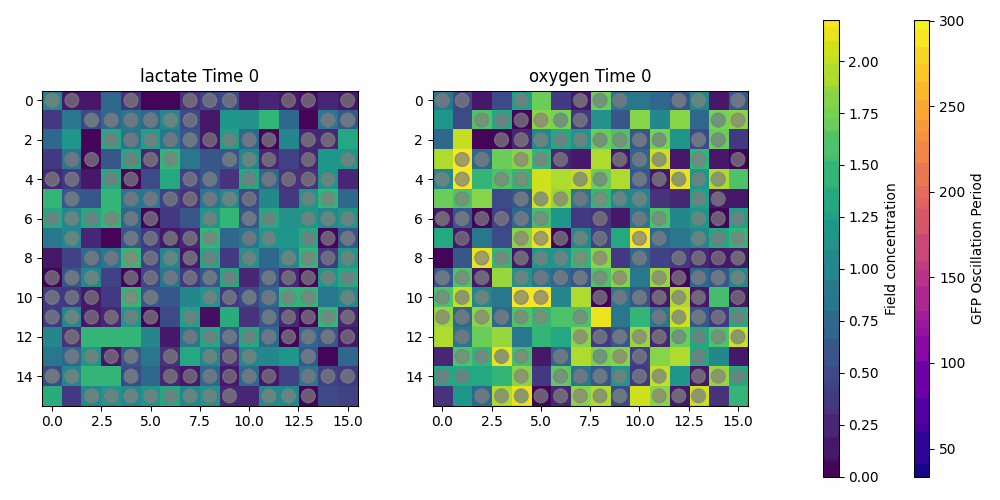

In [10]:
plot_fields_temporal_gif(
    sim_results['fields'], 
    sim_results['cells'], 
    nth_timestep=20, 
    window_size=600,
    filename='grid_temporal.gif'
)

### grid figure

In [11]:
def plot_grid(simulation_data, num_rows, num_cols, out_dir='out', filename=None):
    # Set up figure dimensions
    fig_width = num_cols * 0.8
    fig_height = num_rows * 0.8
    fig = plt.figure(figsize=(fig_width, fig_height))
    gs = gridspec.GridSpec(num_rows, num_cols, figure=fig, wspace=0, hspace=0)

    # Get colormap
    colormap = plt.get_cmap('Set1')
    color_count = colormap.N

    # Dictionary to store all the plot handles for legend
    plot_handles = {}
    species_color = {}  # To store color assignment for each species

    for x in range(num_rows):
        for y in range(num_cols):
            ax = fig.add_subplot(gs[x, y])
            ax.set_yscale('log')
            ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

            # Construct cell_id and get data
            cell_id = f'[{x},{y}]'
            cell_data = simulation_data.get(cell_id, {})
            internal_store = cell_data.get('internal_store', {})

            # Plot data if available
            for i, (species, data) in enumerate(internal_store.items()):
                if species not in species_color:
                    # Assign color from colormap cycling through if more species than colors
                    species_color[species] = colormap(i % color_count)
                if isinstance(data, (list, tuple)) and all(isinstance(x, (int, float)) for x in data):
                    ax.plot(data, label=species, linewidth=1.5, color=species_color[species])
                else:
                    print(f"Skipping non-numeric or empty data for species '{species}' at {cell_id}.")
                # Ensure empty plots look empty
                if not data:
                    ax.axis('off')

            # Update handles for legend
            handles, labels = ax.get_legend_handles_labels()
            for label, handle in zip(labels, handles):
                if label not in plot_handles:
                    plot_handles[label] = handle

    # Adjust figure padding and add a legend
    fig.subplots_adjust(right=0.85)  # Leave space for the legend on the right
    legend = fig.legend(
        plot_handles.values(), 
        plot_handles.keys(), loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='large')

    # Save the figure if a filename is provided
    if filename:
        os.makedirs(out_dir, exist_ok=True)
        fig_path = os.path.join(out_dir, filename)
        print(f"Writing {fig_path}")
        fig.savefig(fig_path, bbox_inches='tight')

    return fig

In [12]:
len(sim_results['fields']['oxygen'][0])

16

In [13]:
sim_results['cells'].keys()

dict_keys(['[0,0]', '[0,1]', '[0,4]', '[0,7]', '[0,8]', '[0,9]', '[0,12]', '[0,13]', '[0,15]', '[1,2]', '[1,3]', '[1,4]', '[1,5]', '[1,6]', '[1,7]', '[1,14]', '[1,15]', '[2,3]', '[2,4]', '[2,5]', '[2,6]', '[2,7]', '[2,8]', '[2,9]', '[2,10]', '[2,11]', '[2,13]', '[2,14]', '[3,1]', '[3,2]', '[3,4]', '[3,5]', '[3,6]', '[3,9]', '[3,10]', '[3,11]', '[3,13]', '[3,15]', '[4,0]', '[4,1]', '[4,3]', '[4,4]', '[4,7]', '[4,8]', '[4,10]', '[4,11]', '[4,12]', '[4,13]', '[4,14]', '[5,1]', '[5,4]', '[5,5]', '[5,6]', '[5,7]', '[5,8]', '[5,9]', '[5,10]', '[5,13]', '[5,14]', '[6,0]', '[6,1]', '[6,2]', '[6,3]', '[6,4]', '[6,5]', '[6,8]', '[6,10]', '[6,11]', '[6,13]', '[6,14]', '[6,15]', '[7,1]', '[7,4]', '[7,5]', '[7,6]', '[7,7]', '[7,8]', '[7,10]', '[7,11]', '[7,13]', '[7,14]', '[7,15]', '[8,2]', '[8,3]', '[8,4]', '[8,5]', '[8,6]', '[8,7]', '[8,8]', '[8,10]', '[8,12]', '[8,13]', '[8,14]', '[8,15]', '[9,0]', '[9,1]', '[9,2]', '[9,4]', '[9,5]', '[9,6]', '[9,7]', '[9,8]', '[9,9]', '[9,11]', '[9,12]', '[9,13

Writing out/results_by_cell2


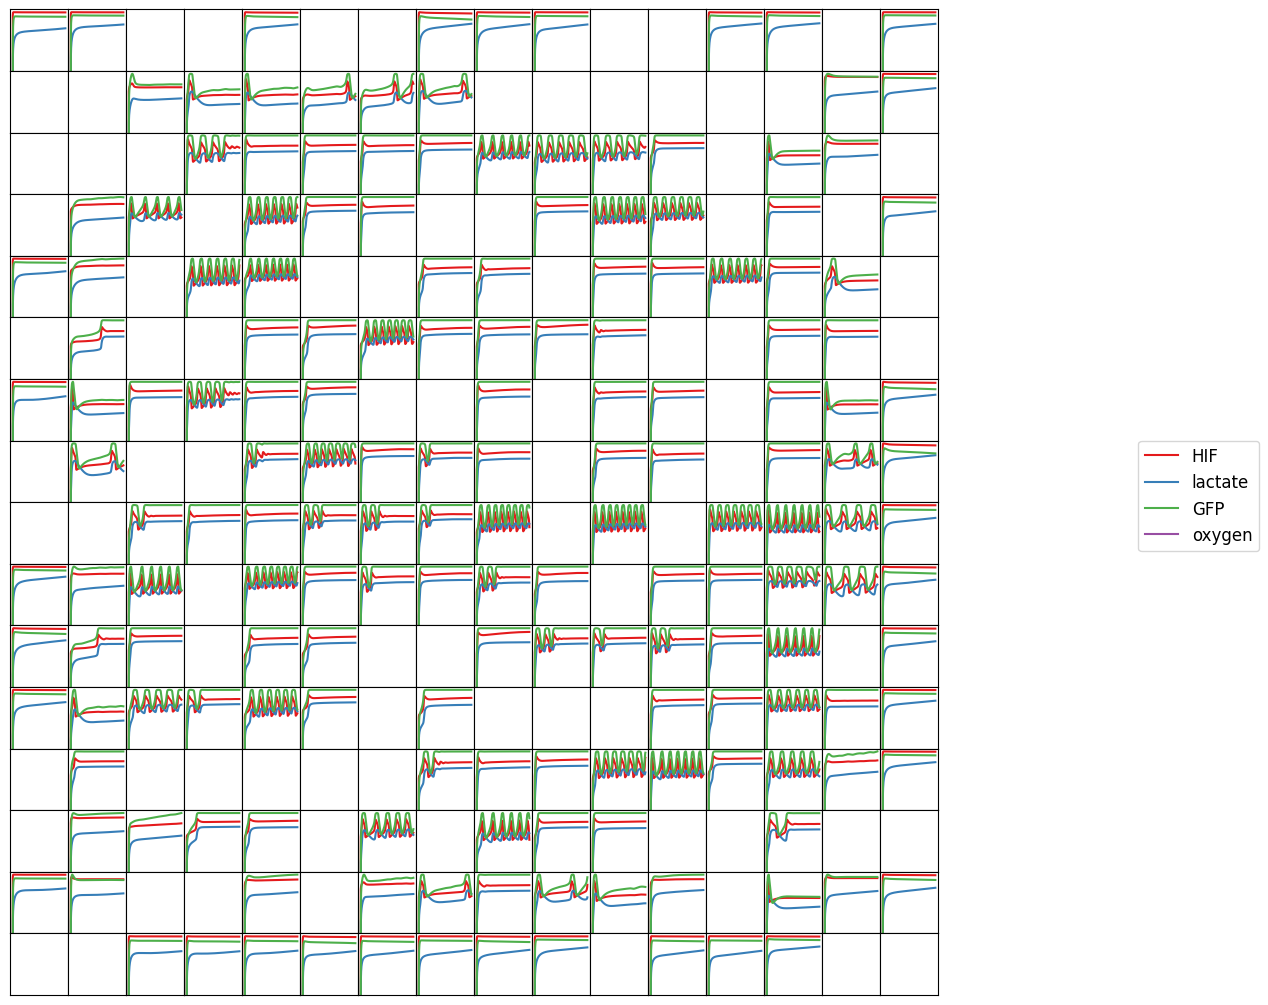

In [14]:
# plot results
results_fig = plot_grid(
    sim_results['cells'],
    num_rows=sim_results['dimensions']['n_bins'][0][0],
    num_cols=sim_results['dimensions']['n_bins'][0][1],
    filename=f'results_by_cell2'
)
# results_fig.show()

### snapshots figure

In [15]:
def plot_fields_snapshots(fields_dict, cells_dict, n_frames, window_size=500, out_dir='out', filename='snapshots.png'):
    oscillation_molecule = 'GFP'

    # Ensure the output directory exists
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    field_limits = {}
    for field_name, matrices in fields_dict.items():
        field_min = np.min([np.min(matrix) for matrix in matrices])
        field_max = np.max([np.max(matrix) for matrix in matrices])
        field_limits[field_name] = (field_min, field_max)

    max_time_points = max(len(matrices) for matrices in fields_dict.values())
    snapshot_indices = np.linspace(0, max_time_points - 1, n_frames, dtype=int)

    num_fields = len(fields_dict)
    fig = plt.figure(figsize=(3 * n_frames, 3 * num_fields))
    gs = gridspec.GridSpec(num_fields, n_frames + 1, width_ratios=[*([1] * n_frames), 0.05])  # Additional space for color bars

    for f_idx, (field_name, matrices) in enumerate(fields_dict.items()):
        for t_idx, time_point in enumerate(snapshot_indices):
            ax = fig.add_subplot(gs[f_idx, t_idx])
            if time_point < len(matrices):
                min_val, max_val = field_limits[field_name]
                cax = ax.imshow(np.array(matrices[time_point]), cmap='viridis', vmin=min_val, vmax=max_val, interpolation='nearest')

                if f_idx == 0:
                    ax.set_title(f"Time {time_point}")
                if t_idx == 0:
                    ax.set_ylabel(field_name)

                for cell_key, cell_data in cells_dict.items():
                    coords = ast.literal_eval(cell_key)
                    if 'internal_store' in cell_data and oscillation_molecule in cell_data['internal_store']:
                        windowed_signal = cell_data['internal_store'][oscillation_molecule][max(0, time_point - window_size):time_point]
                        period = detect_oscillation_period(windowed_signal)
                        color = 'red' if period else 'grey'
                        ax.add_patch(Circle((coords[1], coords[0]), radius=0.35, color=color, alpha=0.7))

            if t_idx == n_frames - 1:
                cbar_ax = fig.add_subplot(gs[f_idx, -1])
                plt.colorbar(cax, cax=cbar_ax)

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.tight_layout()
    filename = os.path.join(out_dir, filename)
    plt.savefig(filename)
    plt.close(fig)

    return fig

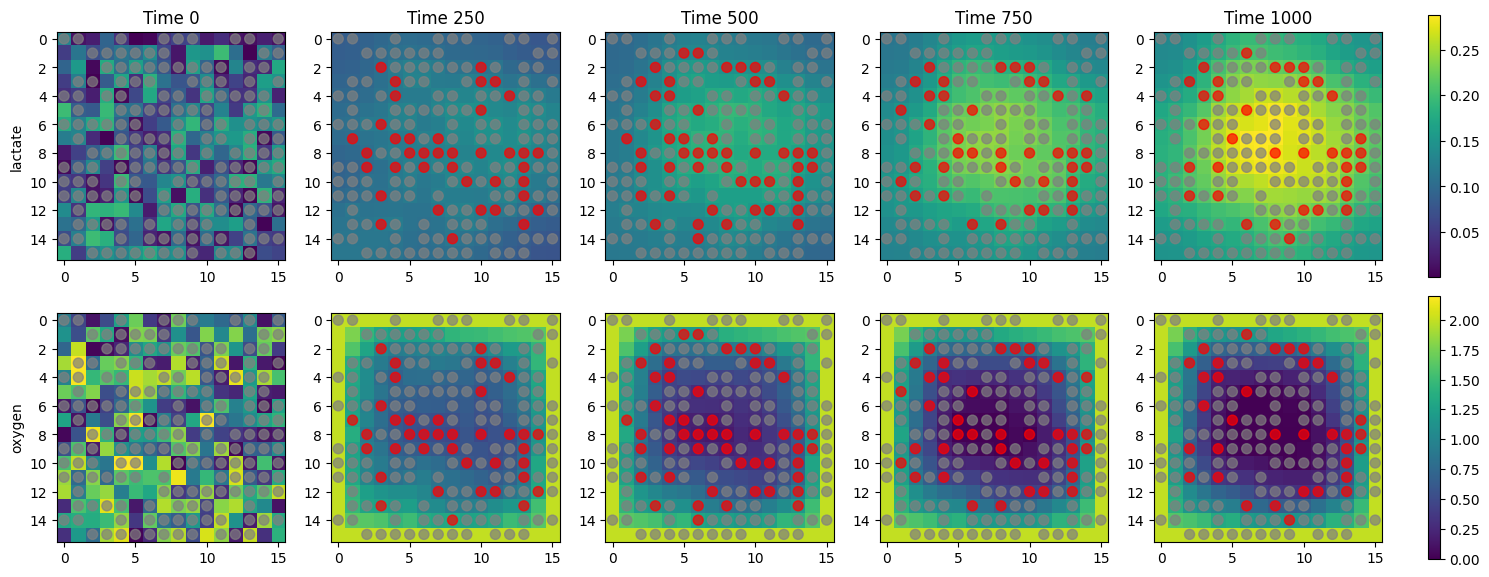

In [16]:
plot_fields_snapshots(
    sim_results['fields'], 
    sim_results['cells'], 
    n_frames=5,
    window_size=600,
)

## Distribution plots

In [69]:
def plot_distribution(cell_results, variable='HIF', bins=50):
    values = []
    for cell, store in cell_results.items():
        if variable in store['internal_store']:
            values.append(store['internal_store'][variable][-1])
            
    # plot the distribution
    plt.hist(values, bins=bins)
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.title(f'{variable} Distribution')
    plt.show()
    
def plot_oscillation_distribution(cell_results, variable='HIF', bins=50):
    var_values = []
    osc_values = []
    for cell, store in cell_results.items():
        if variable in store['internal_store']:
            var_values.append(store['internal_store'][variable][-1])
            
            # detect oscillation
            period = detect_oscillation_period(store['internal_store']['GFP'])
            if period == None:
                period = 0
            osc_values.append(period)
            
    # sort var_values and osc_values by var_values
    # var_values, osc_values = zip(*sorted(zip(var_values, osc_values)))
    
    # bin 
            
    # create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(6, 6))
    
    # the first subplot plots the distribution
    axs[0].hist(var_values, bins=bins)
    axs[0].set_xlabel(variable)
    axs[0].set_ylabel('Frequency')
    axs[0].set_title(f'{variable} Distribution')
    
    # get the indices of the var_values corresponding to each bin
    ## first, get array of bins. It has to be 1-dimensional and monotonic.
    bins_array = np.linspace(min(var_values), max(var_values), bins)

    # digitize
    bin_indices = np.digitize(var_values, bins_array)
    
    # get oscillation period for each index in bin_indices
    oscillations_per_bin = {}
    for index, bin_index in enumerate(bin_indices):
        if bin_index not in oscillations_per_bin:
            oscillations_per_bin[bin_index] = []
        oscillations_per_bin[bin_index].append(osc_values[index])
        
    # get percent oscillating for each bin
    percent_oscillating = {}
    for bin_index, oscillation_periods in oscillations_per_bin.items():
        percent_oscillating[bin_index] = len([x for x in oscillation_periods if x > 0]) / len(oscillation_periods)
    
    # the second subplot plots the percent oscillating corresponding to each bin of the first subplot
    axs[1].bar(percent_oscillating.keys(), percent_oscillating.values())
    axs[1].set_xlabel(variable)
    axs[1].set_ylabel('Percent Oscillating')
    
    plt.tight_layout()
    plt.show()


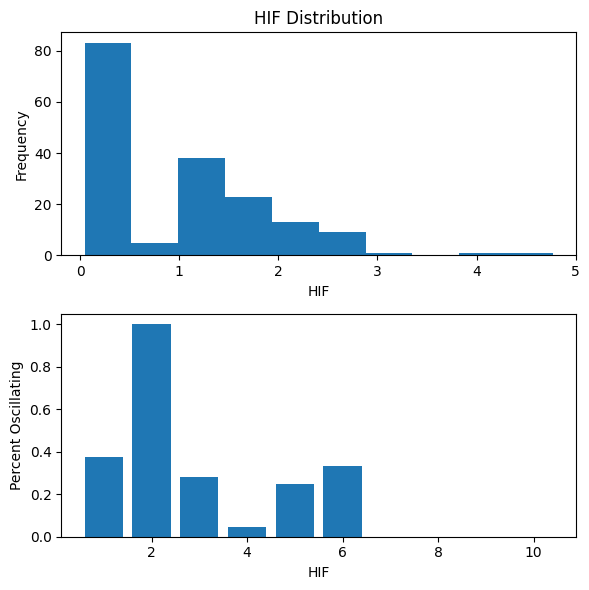

In [70]:
plot_oscillation_distribution(sim_results['cells'], variable='HIF', bins=10)

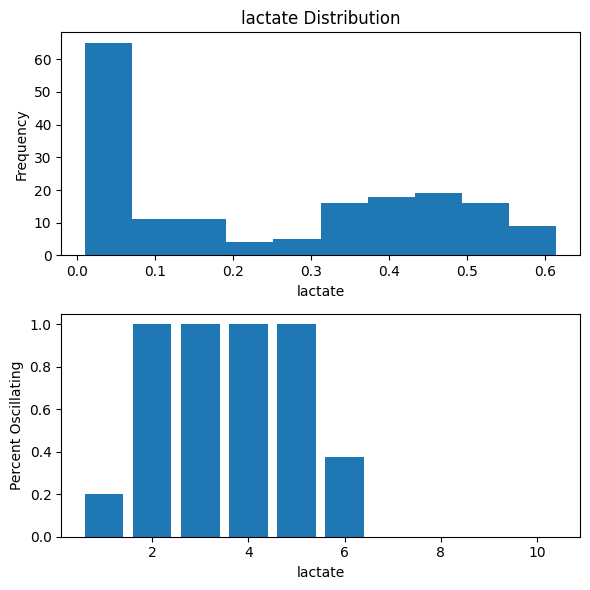

In [74]:
plot_oscillation_distribution(sim_results['cells'], variable='lactate', bins=10)

In [73]:
sim_results['cells']['[7,1]']['internal_store'].keys()

dict_keys(['HIF', 'lactate', 'GFP', 'oxygen'])